## Set up

Set up the code

In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

# Imports for pytorch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from scipy.stats import linregress
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.metrics import root_mean_squared_error

# Local imports
from src import process
from src import models

In [3]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
resolution_vector = process.get_target_df(df_format=False)
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)
# markets_df = process.get_current_probs()
# blind_mode_df["brier_score"] = brier_score

In [4]:
# Remove participants who didn't answer the full questionaire
# Define as if there is an blind_mode_feature_df["Age"] value that is not nan

use_only_complete_data = True
if use_only_complete_data:
    good_participants = ~blind_mode_feature_df["Age"].isna()
    blind_mode_feature_df = blind_mode_feature_df[good_participants]
    brier_score = brier_score[good_participants]
# Create a new dataframe with the columns we want to use
use_subset_features = True
if use_subset_features:
    columns_to_use = [
        "ForecastingExperience",
        "DonaldTrump",
        "Immigration",
        "GlobalWarming",
        "Atheist",
        "Drugaddiction",
        "PTSD",
        "MoodScale",
    ]
    blind_mode_feature_df = blind_mode_feature_df[columns_to_use]
else:
    columns_to_use = blind_mode_feature_df.columns.tolist()

In [5]:
# Set up data
blind_mode_df_pytorch = blind_mode_feature_df[columns_to_use]

# Split into train and test sets
X = blind_mode_df_pytorch.values
y = np.expand_dims(brier_score, 1)

# Convert nans to the mean
X_column_means = np.nanmean(X, axis=0)
X = np.nan_to_num(X, nan=X_column_means)

# Perform feature normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

## Base model

In [6]:
# Initialize and train the model
params = models.get_default_params()

# Override some parameters
params.hidden_layer_sizes = [50, 500, 50]
params.weight_decay = 0.01

seed = 42
torch.manual_seed(seed)
print(f"Using device: {params.device}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, train_size=params.train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

Using device: cuda


Epoch [ 100/1000], Train loss: 00.0021, Test loss: 00.0024, Run Time: 02.78
Epoch [ 200/1000], Train loss: 00.0019, Test loss: 00.0023, Run Time: 05.40
Epoch [ 300/1000], Train loss: 00.0017, Test loss: 00.0022, Run Time: 08.02
Epoch [ 400/1000], Train loss: 00.0016, Test loss: 00.0022, Run Time: 10.61
Epoch [ 500/1000], Train loss: 00.0017, Test loss: 00.0022, Run Time: 13.27
Epoch [ 600/1000], Train loss: 00.0016, Test loss: 00.0022, Run Time: 15.91
Epoch [ 700/1000], Train loss: 00.0016, Test loss: 00.0022, Run Time: 18.48
Epoch [ 800/1000], Train loss: 00.0016, Test loss: 00.0022, Run Time: 21.10
Epoch [ 900/1000], Train loss: 00.0016, Test loss: 00.0022, Run Time: 23.83
Epoch [1000/1000], Train loss: 00.0017, Test loss: 00.0022, Run Time: 26.47


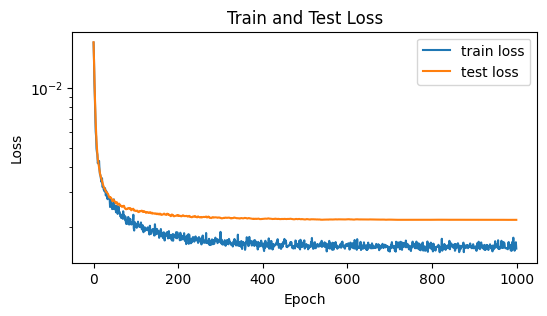

Neural net Loss: 0.0021766
Mean model loss: 0.0020254


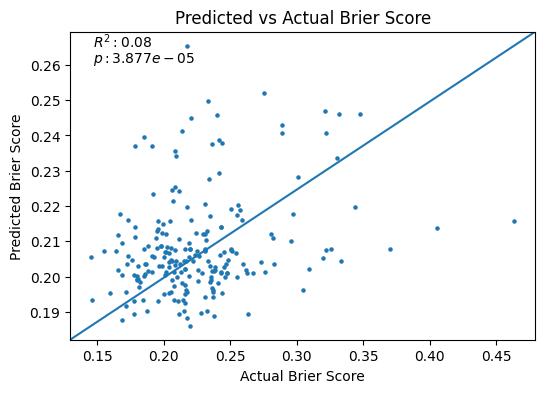

In [7]:
# Create the model
input_size = X_train.shape[1]
base_model = models.Net(input_size, params.hidden_layer_sizes)
# input_n = input_size
# n_hidden_units = 10
# output_n = 1
# base_model = base_model.MLPcondensed(input_n, n_hidden_units, output_n)
base_model = base_model.to(params.device)

# Set up for training
optimizer = torch.optim.Adam(
    params=base_model.parameters(), lr=params.lr, weight_decay=params.weight_decay
)
scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
loss_function = nn.MSELoss()

# Train model
train_loss, test_loss = models.train_and_evaluate(
    base_model, train_loader, test_loader, scheduler, optimizer, loss_function, params
)

# Plot train and test loss
fig = plt.figure(figsize=(6, 3))
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.yscale("log")
plt.legend()
plt.show()

base_model.eval()
y_pred = base_model(X_test)
loss = loss_function(y_pred, y_test)
print(f"Neural net Loss: {loss:.7f}")

# Calcualte loss of the mean-model
mean_model_pred = y_test.mean() * torch.ones_like(y_test)
mean_loss = loss_function(mean_model_pred, y_test)
print(f"Mean model loss: {mean_loss:.7f}")


# Plot predictions against actual values
x = y_test.cpu().numpy()
y = y_pred.cpu().detach().numpy()
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.scatter(x, y, s=5)
ax.set_xlabel("Actual Brier Score")
ax.set_ylabel("Predicted Brier Score")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
# Calculate correlation
nan_mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, _ = linregress(x[nan_mask], y[nan_mask])
ax.text(0.05, 0.95, f"$R^2: {r_value**2:.2f}$", transform=ax.transAxes)
ax.text(0.05, 0.9, f"$p: {p_value:.4g}$", transform=ax.transAxes)
ax.set_title("Predicted vs Actual Brier Score")
# Make axis limits the same
min_lim = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
# ax.set_xlim([min_lim, max_lim])
# ax.set_ylim([min_lim, max_lim])
plt.show()

## Hyperopt

In [8]:
# Define the space over which hyperopt will search for optimal hyperparameters.

space = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-5), np.log(1e-2)),
    "weight_decay": hp.loguniform("weight_decay", np.log(1e-5), np.log(1e-1)),
    "gamma": hp.uniform("gamma", 0.9, 0.999),
    # Fixed
    "log_interval": np.inf,
}

In [9]:
# Define the hyperopt objective.
def hyperparameter_tuning(space, verbose=True):
    # Set up the parameters
    # Variable
    params.lr = space["learning_rate"]
    params.weight_decay = space["weight_decay"]
    params.gamma = space["gamma"]
    # Fixed
    params.log_interval = space["log_interval"]

    # Create the model
    input_size = X_train.shape[1]
    model = models.Net(input_size, params.hidden_layer_sizes)
    model = model.to(params.device)

    # Set up for training
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=params.lr, weight_decay=params.weight_decay
    )
    scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
    loss_function = nn.MSELoss()

    # Train model
    _, _ = models.train_and_evaluate(
        model, train_loader, test_loader, scheduler, optimizer, loss_function, params
    )
    model.eval()
    y_pred = model(X_test)
    loss = loss_function(y_pred, y_test)

    if verbose:
        print(f"Using varied parameters: {space}")
        print(f"                   Loss: {loss}")
    return {"loss": loss, "status": STATUS_OK, "model": model}

In [10]:
# Run trials.
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=25,
    trials=trials,
)
print(f"Best hyperparameters: {best}")

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

Using varied parameters: {'gamma': 0.9274222995111744, 'learning_rate': 0.001703519857966552, 'log_interval': inf, 'weight_decay': 3.7065208826088676e-05}
                   Loss: 0.002179448725655675         
Using varied parameters: {'gamma': 0.9869595380419517, 'learning_rate': 0.007233449040542227, 'log_interval': inf, 'weight_decay': 3.6147620227604455e-05}
                   Loss: 0.0020143971778452396                                    
Using varied parameters: {'gamma': 0.9262898287410192, 'learning_rate': 0.002968258181665637, 'log_interval': inf, 'weight_decay': 0.011069395186183146}
                   Loss: 0.0021357969380915165                                     
Using varied parameters: {'gamma': 0.9672571550301621, 'learning_rate': 0.002184362732791014, 'log_interval': inf, 'weight_decay': 8.875148833136843e-05}
                   Loss: 0.0020165436435490847                                     
Using varied parameters: {'gamma': 0.9293927268203058, 'learning_rate': 2.797

In [15]:
# Create instace of best model.
best_model = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]

# Examine model hyperparameters
best_model_loss = trials.results[np.argmin([r["loss"] for r in trials.results])]["loss"]
print(f"Final loss (MSE): {best_model_loss:.8f}")
print(f"Best optimized hyperparameters:\n{space_eval(space, best)}")

# Final loss (MSE): 0.00188757
# Best optimized hyperparameters:
# {'gamma': 0.9988758866204159, 'learning_rate': 0.0012686250127603039, 'log_interval': inf, 'weight_decay': 0.00018150560940835526}

Final loss (MSE): 0.00188757
Best optimized hyperparameters:
{'gamma': 0.9988758866204159, 'learning_rate': 0.0012686250127603039, 'log_interval': inf, 'weight_decay': 0.00018150560940835526}


In [12]:
best_model.eval()
best_model_score = root_mean_squared_error(
    y_test.cpu(), best_model(X_test).cpu().detach().numpy()
)
print("Best Model RMSE:", best_model_score)
#
base_model_score = root_mean_squared_error(
    y_test.cpu(), base_model(X_test).cpu().detach().numpy()
)
print("Base model RMSE:", base_model_score)
# MSE from guessing the mean of the training set
mean_model_score = root_mean_squared_error(
    y_test.cpu(), np.full(y_test.shape, np.mean(y_train.cpu().detach().numpy()))
)
print("Mean model RMSE:", mean_model_score)

Best Model RMSE: 0.043446127
Base model RMSE: 0.04665405
Mean model RMSE: 0.04565654
